In [2]:
import os
import sys

# For one-level deep notebook
BASE_DIR = os.path.abspath("../")
if BASE_DIR not in sys.path:
    sys.path = [BASE_DIR] + sys.path

from typing import List, Tuple

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
folder = "../results"
results_datasets = [
    "baseline_measurements.parquet",
    "bilateral.parquet",
    "blur.parquet",
    "gaussblur.parquet",
    "mean.parquet",
    "medianblur.parquet",
    "nml_fastnl.parquet",
    "nml_multi_fastnl.parquet",
    "pca.parquet",
]


In [4]:
# Read and join all (except deep image prior) result sets
# Deep_image_prior.parquet is not included because it has a different format compared to the other results

results = []
for file in results_datasets:
    file_path = os.path.join(folder, file)
    results.append(pd.read_parquet(file_path))

results = pd.concat(results, axis="index").reset_index()
results = results.groupby(
    by=["denoise_function", "img_id", "noise_type"], as_index=False
).agg(
    mse=("mse", "mean"),
    ssim=("ssim", "mean"),
    psnr=("psnr", "mean"),
)

In [5]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   denoise_function  2700 non-null   object 
 1   img_id            2700 non-null   int64  
 2   noise_type        2700 non-null   object 
 3   mse               2700 non-null   float64
 4   ssim              2700 non-null   float64
 5   psnr              2700 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 126.7+ KB


In [23]:
# Load deep image prior results
deep_image_prior = pd.read_parquet(os.path.join(folder, "deep_image_prior.parquet"))
dip_min_mse_idx = deep_image_prior.groupby(by=["img_id", "noise_type"]).agg(idx=("mse", "idxmin")) # index of the best result for each image and noise type
deep_image_prior = deep_image_prior.iloc[dip_min_mse_idx["idx"]].drop(columns=["epoch"])
deep_image_prior.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 17 to 153
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   denoise_function  9 non-null      object 
 1   img_id            9 non-null      int64  
 2   noise_type        9 non-null      object 
 3   mse               9 non-null      float64
 4   ssim              9 non-null      float64
 5   psnr              9 non-null      float64
dtypes: float64(3), int64(1), object(2)
memory usage: 504.0+ bytes


In [24]:
# Append deep image prior results to the rest
results = pd.concat([results, deep_image_prior], axis="index")
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2709 entries, 0 to 153
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   denoise_function  2709 non-null   object 
 1   img_id            2709 non-null   int64  
 2   noise_type        2709 non-null   object 
 3   mse               2709 non-null   float64
 4   ssim              2709 non-null   float64
 5   psnr              2709 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 148.1+ KB


In [25]:
def normalize_results(
    df: pd.DataFrame, category_field: str, baseline_category: str
) -> pd.DataFrame:
    results = df.copy()

    dims = set(results[category_field].unique())
    # dims.remove(baseline_category)
    baseline = results.loc[
        results[category_field] == baseline_category, ["mse", "ssim", "psnr"]
    ]

    for dim in dims:
        results.loc[results[category_field] == dim, ["mse", "ssim", "psnr"]] = (
            results.loc[results[category_field] == dim, ["mse", "ssim", "psnr"]]
            / baseline
        )

    return results


replace_values = {
    "denoise_function": {
        "blur": "Blur",
        "gaussian blur": "Gaussian Blur",
        "median blur": "Median Blur",
        "bilateral filtering": "Bilateral Filtering",
        "FastNl": "Non-Local Means",
        "mean": "Image Fusion (Mean)",
        "pca": "Image Fusion (PCA)",
        "Deep Image Prior": "Deep Image Prior",
    }
}


results_normalized = normalize_results(
    results.set_index(["img_id", "noise_type"]), "denoise_function", "None"
)
results_normalized = results_normalized.loc[
    results_normalized["denoise_function"] != "None", :
]
results_normalized = results_normalized.replace(replace_values)

In [26]:
results_normalized.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2409 entries, (0, 'gaussian') to (62, 'speckle')
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   denoise_function  2409 non-null   object 
 1   mse               2409 non-null   float64
 2   ssim              2409 non-null   float64
 3   psnr              2409 non-null   float64
dtypes: float64(3), object(1)
memory usage: 85.1+ KB


In [35]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)


def plot_scatter(
    df: pd.DataFrame,
    x: str,
    y: str,
    hue: str,
    plot_title: str = "Scatter Plot",
    alpha: float = 0.8,
    ylim: Tuple[float, float] = (0, 2),
    order: List[str] = None,
    xlabel:str = None,
    ylabel:str = None,
):
    """
    Plot scatter plot by category hue

    Args:
        df (pd.DataFrame): data
        x (str): x-axis
        y (str): y-axis
        hue (str): category to plot by
        plot_title (str, optional): Title of plot. Defaults to "Scatter Plot".
        alpha (float, optional): Alpha/transparency value. Defaults to 0.8.
    """
    if not xlabel:
        xlabel = x
    if not ylabel:
        ylabel = y

    fig = plt.figure(figsize=(12, 7))
    ax = sns.stripplot(df, x=x, y=y, hue=hue, alpha=alpha, order=order, jitter=0.2)
    wrap_labels(ax, 10)
    plt.ylim(bottom=ylim[0], top=ylim[1])
    plt.axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5)
    plt.title(plot_title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

/tmp/ipykernel_6714/562216032.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=0)


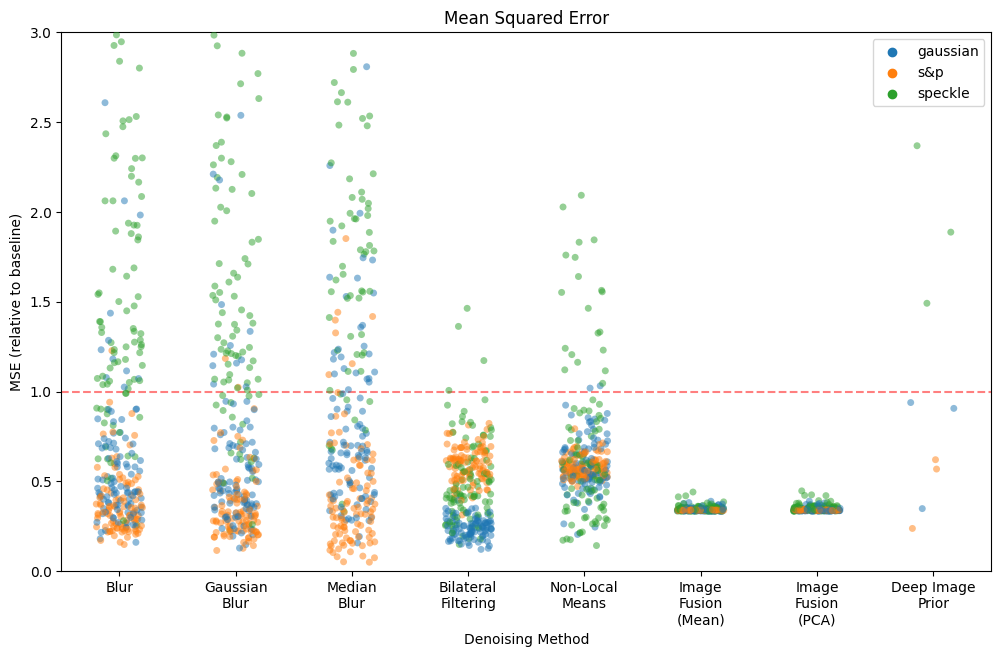

/tmp/ipykernel_6714/562216032.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=0)


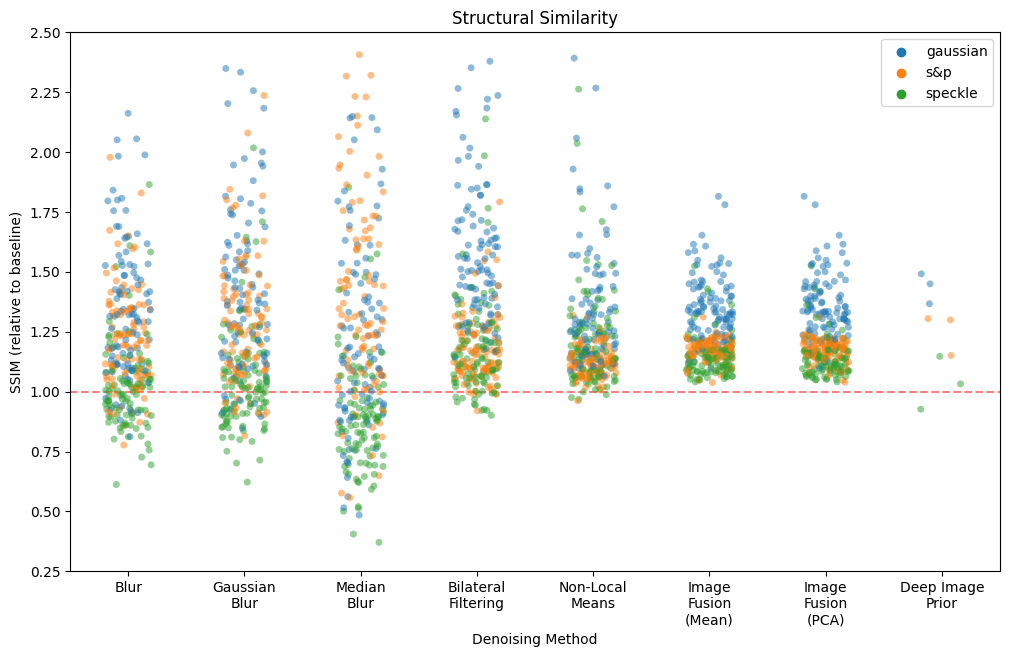

/tmp/ipykernel_6714/562216032.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=0)


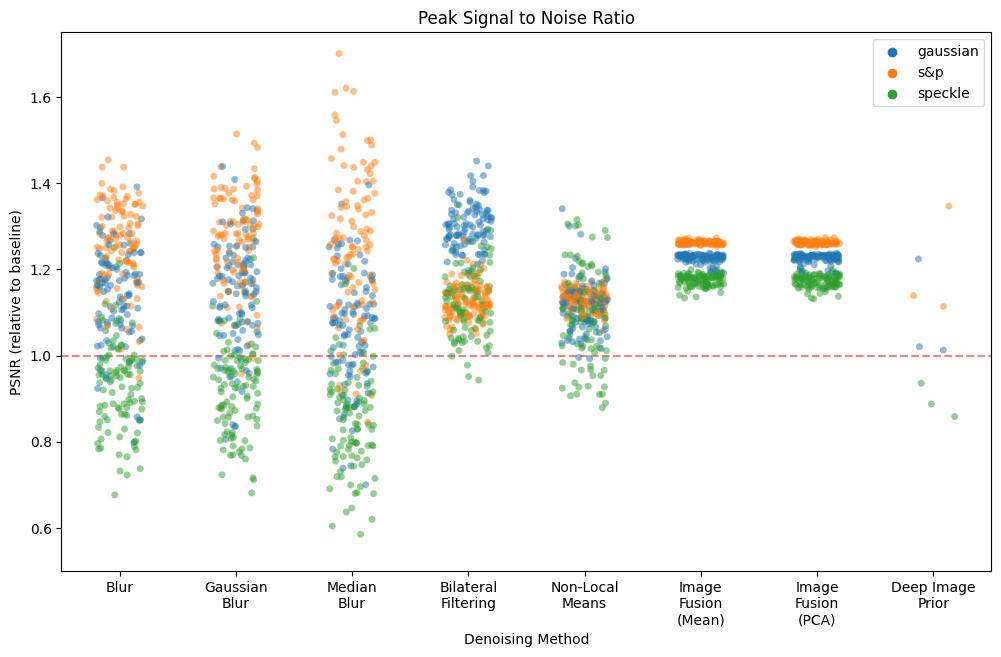

In [36]:
plot_scatter(
    results_normalized.reset_index(),
    x="denoise_function",
    y="mse",
    alpha=0.5,
    hue="noise_type",
    plot_title="Mean Squared Error",
    ylim=(0, 3),
    order=replace_values["denoise_function"].values(),
    xlabel="Denoising Method",
    ylabel="MSE (relative to baseline)",
)
plot_scatter(
    results_normalized.reset_index(),
    x="denoise_function",
    y="ssim",
    alpha=0.5,
    hue="noise_type",
    plot_title="Structural Similarity",
    ylim=(0.25, 2.5),
    order=replace_values["denoise_function"].values(),
    xlabel="Denoising Method",
    ylabel="SSIM (relative to baseline)",

)
plot_scatter(
    results_normalized.reset_index(),
    x="denoise_function",
    y="psnr",
    alpha=0.5,
    hue="noise_type",
    plot_title="Peak Signal to Noise Ratio",
    ylim=(0.5, 1.75),
    order=replace_values["denoise_function"].values(),
    xlabel="Denoising Method",
    ylabel="PSNR (relative to baseline)",
)

## Notes
1. Bluring techniques do better with S&P noise as seen using MSE and PSNR metrics
2. Mean/PCA provides extremely consistent and similar results
3. Bilateral filtering handles gaussian noise very well.
4. Non-local means provides consistent results for S&P noise
5. Speckle (multiplicative) noise is generally the most difficult to reduce.